# Logistic Regression on Titanic Data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# 1) Data Preparation
- Import titanic dataset
- analyse the data
- identify the missing values and work on the missing values

## 1.1) Import the data

In [2]:
titanic_df = pd.read_csv('titanic.csv')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1.2) Analyse the data

In [3]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


The <b>Survived</b> column is our target/dependent/reponse variable, 1 means the passenger survived, 0 means that the passenger died. 

Several other variables describe the passengers:
- PassengerId: and id given to each traveler on the boat.
- Pclass: the passenger class. It has three possible values: 1,2,3.
- Name
- Sex
- Age
- SibSp: number of siblings and spouses traveling with the passenger
- Parch: number of parents and children traveling with the passenger
- The ticket number
- The ticket fare
- The cabin number
- The port of embarkation. It has three possible values S,C,Q. (C = Cherbourg; Q = Queenstown; S = Southampton) 

Let us check which records in the training data are missing information for the Embarked field. 

## 1.3) Drop the columns where all elements are missing values:

There are 12 columns in total with the following information

In [4]:
titanic_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

#### Find the columns that has null for any columns

In [5]:
titanic_df.columns[titanic_df.isnull().all()].tolist()

[]

##### There are no columns.

## 1.4) Feature Engineering

Before working on missing data, I want to work on creating new features that might be relevant.

- Total number of passengers in the cabin can be found by adding sibsp and parch with the individual (1)
- Individual Fare per passenger can be calculated
- Deck number can be identified from Cabin
- Title can be derived from the name

### 1.4.1) Total Passengers

In [8]:
titanic_df['NumPassengersInCabin'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1

### 1.4.2) FarePerPassenger - approximate

In [9]:
titanic_df['FarePerPassenger'] = titanic_df['Fare']/titanic_df['NumPassengersInCabin']

### 1.4.3) Deck

In [10]:
titanic_df['Deck'] = titanic_df.Cabin.str[:1]
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NumPassengersInCabin,FarePerPassenger,Deck
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,3.62500,NaN
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,35.64165,C


### 1.4.4) Title from Passenger Name

In [11]:
titanic_df['Title'] = titanic_df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
titanic_df[['Name','Title']].head(2)

,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs


In [13]:
pd.crosstab(titanic_df['Title'], titanic_df.Sex)

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


The above data seems to be pretty accurate

In [14]:
# Mlle, traditionally given to an unmarried woman.
# Mme for woman - married
titanic_df.Title = titanic_df.Title.replace('Mlle', 'Miss')
titanic_df.Title = titanic_df.Title.replace('Ms', 'Miss')
titanic_df.Title = titanic_df.Title.replace('Mme', 'Mrs')

## 1.5) Fill Missing values:

In [15]:
titanic_df.isnull().sum()[titanic_df.isnull().sum()>0]

Age         177
Cabin       687
Embarked      2
Deck        687
dtype: int64

#### Age has 177 missing values, Deck 687 and Embarked 2 missing values

### 1.5.1) Missing Data: Embarked

In [16]:
titanic_df['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [17]:
#Lets check which rows have null Embarked column
titanic_df[titanic_df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NumPassengersInCabin,FarePerPassenger,Deck,Title
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN,1,80.0,B,Miss
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN,1,80.0,B,Mrs


In [18]:
#Pclass1 is missing Embarked values with Fare =80. We need to find the embarkation point for most of passengers with that price range.
# Need not necessarily pclass=1
titanic_df[titanic_df['Pclass']==1]['Embarked'].value_counts()

S    127
C     85
Q      2
Name: Embarked, dtype: int64

In [19]:
titanic_df[['Embarked','Pclass', 'FarePerPassenger']][(titanic_df.FarePerPassenger>75) & (titanic_df.FarePerPassenger <85)]

,Embarked,Pclass,FarePerPassenger
61,NaN,1,80.00000
139,C,1,79.20000
218,C,1,76.29170
256,C,1,79.20000
268,S,1,76.73125
290,S,1,78.85000
310,C,1,83.15830
332,S,1,76.73125
627,S,1,77.95830
681,C,1,76.72920


In [20]:
titanic_df['Embarked'][(titanic_df.FarePerPassenger>75) & (titanic_df.FarePerPassenger <85)].value_counts()

C    6
S    4
Name: Embarked, dtype: int64

#### There are 3 classes S, C, Q 
We can infer that the Embarkation point 'C' is the most occuring for fare price range 75 - 85 (which is also pclass=1). 
Lets replace the missing Embarked values with 'C'

In [21]:
titanic_df['Embarked'] = titanic_df['Embarked'].fillna('C')

### 1.5.2) Missing Value: Cabin/Deck

In [24]:
titanic_df['Deck'].describe()

count     204
unique      8
top         C
freq       59
Name: Deck, dtype: object

In [25]:
titanic_df['Deck'].isnull().sum()

687

In [26]:
titanic_df[['Pclass', 'Deck']].groupby(['Pclass']).count()

,Deck
Pclass,
1,176
2,16
3,12


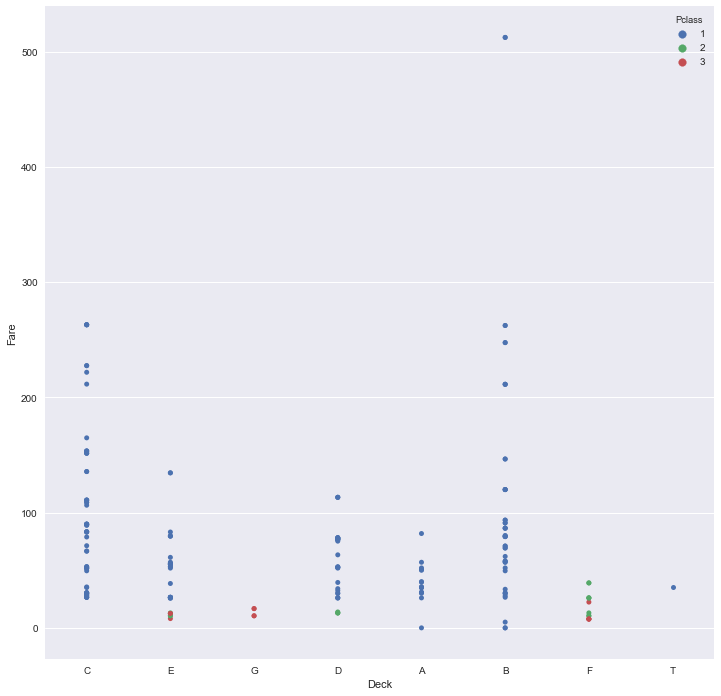

In [27]:
f, ax = plt.subplots(figsize=(12, 12))
sns.set(style="whitegrid")
sns.stripplot('Deck', 'Fare', data=titanic_df, hue='Pclass')

In [28]:
titanic_df[['Deck', 'Pclass', "Fare"]].groupby(['Deck', 'Pclass']).count()

Fare
Deck Pclass      
A    1         15
B    1         47
C    1         59
D    1         29
     2          4
E    1         25
     2          4
     3          3
F    2          8
     3          5
G    3          4
T    1          1

In [91]:
titanic_df.FarePerPassenger[(titanic_df.Deck == 'A') & (titanic_df.Fare !=0)].describe()

count    14.000000
mean     35.108679
std       9.823917
min      19.800000
25%      28.848450
50%      32.827100
75%      38.968750
max      52.000000
Name: FarePerPassenger, dtype: float64

In [20]:
titanic_df.Fare[(titanic_df.Deck == 'B') & (titanic_df.Fare !=0)].describe()

count     45.000000
mean     118.550464
std      108.987208
min        5.000000
25%       57.979200
50%       80.000000
75%      120.000000
max      512.329200
Name: Fare, dtype: float64

In [167]:
titanic_df[['Deck', 'FarePerPassenger']][titanic_df.Deck == 'G'].describe()

,FarePerPassenger
count,4.000000
mean,4.963021
std,0.996307
min,3.487500
25%,4.795313
50%,5.398958
75%,5.566667
max,5.566667


### Calculating approximate fare rates for each deck based on the 25th and 75th percentile of IQR

In [30]:
DeckAFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='A'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='A'], 75))/2

DeckBFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='B'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='B'], 75))/2

DeckCFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='C'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='C'], 75))/2

DeckDFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='D'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='D'], 75))/2

DeckEFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='E'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='E'], 75))/2

DeckFFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='F'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='F'], 75))/2

DeckGFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='G'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='G'], 75))/2

DeckTFare = (np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='T'], 25) + np.percentile(titanic_df.FarePerPassenger[titanic_df.Deck=='T'], 75))/2
print("DeckAFare=",DeckAFare,"DeckBFare=", DeckBFare, "DeckCFare=",DeckCFare, "DeckDFare=",DeckDFare)
print("DeckEFare=",DeckEFare, "DeckFFare=",DeckFFare, "DeckGFare=", DeckGFare, "DeckTFare=",DeckTFare)

DeckAFare= 32.843925 DeckBFare= 55.9974 DeckCFare= 40.37605 DeckDFare= 32.454175
DeckEFare= 26.945318750000002 DeckFFare= 8.7 DeckGFare= 5.180989583333334 DeckTFare= 35.5


### THE DECKS WITH LOWER TO HIGHER RATES ARE
DECKG   
DECKF  
DECKE   
DECKD  
DECKA  
DESCT  
DECKC  
DECKB  

Lets populate the values of deck starting from low value

The decks will be populated based on the fare range of the decks as calculated above.

In [31]:
### populate the Deck values based on the fare range ###
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > 0) & (titanic_df.FarePerPassenger <= DeckGFare)] = titanic_df.Deck.fillna('G')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckGFare) & (titanic_df.FarePerPassenger <= DeckFFare)] = titanic_df.Deck.fillna('F')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckFFare) & (titanic_df.FarePerPassenger <= DeckEFare)] = titanic_df.Deck.fillna('E')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckEFare) & (titanic_df.FarePerPassenger <= DeckDFare)] = titanic_df.Deck.fillna('D')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckDFare) & (titanic_df.FarePerPassenger <= DeckAFare)] = titanic_df.Deck.fillna('A')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckAFare) & (titanic_df.FarePerPassenger <= DeckTFare)] = titanic_df.Deck.fillna('T')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckTFare) & (titanic_df.FarePerPassenger <= DeckCFare)] = titanic_df.Deck.fillna('C')
titanic_df.Deck.loc[(titanic_df.FarePerPassenger > DeckCFare)] = titanic_df.Deck.fillna('B')

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [33]:
titanic_df[['Pclass','FarePerPassenger','Deck']][titanic_df.Deck.isnull()]

,Pclass,FarePerPassenger,Deck
179,3,0.0,NaN
271,3,0.0,NaN
277,2,0.0,NaN
302,3,0.0,NaN
413,2,0.0,NaN
466,2,0.0,NaN
481,2,0.0,NaN
597,3,0.0,NaN
633,1,0.0,NaN
674,2,0.0,NaN


In [35]:
#Drop off all the rows wwith passenger fare = 0
titanic_df = titanic_df[titanic_df.FarePerPassenger > 0]
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NumPassengersInCabin,FarePerPassenger,Deck,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,3.62500,G,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,35.64165,C,Mrs


In [36]:
titanic_df.shape

(876, 16)

### 1.5.3) Missing Data: Age

In [37]:
titanic_df['Age'].describe()

count    707.000000
mean      29.645219
std       14.558872
min        0.420000
25%       20.000000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

#### Age ranges from less than 1 to 80 years old with mean age as 30.
Most of the passenger ages are in the range of 21 to 39

Text(0,0.5,'Frequency')

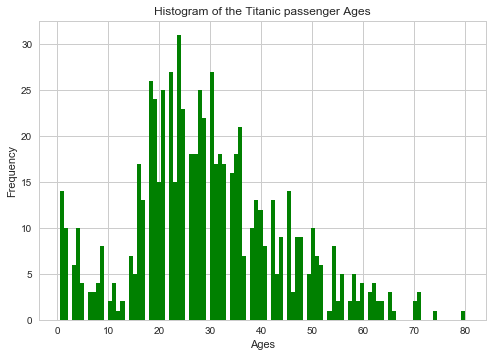

In [38]:
titanic_df['Age'].plot.hist(bins=100, color='green')
Title = 'Histogram of the Titanic passenger Ages'
X = 'Ages'
y = 'Frequency'
plt.title(Title)
plt.xlabel(X)
plt.ylabel(y)     

#### I want to specify the Age based on the Title from the name
Age for all titles with Mr will be the mean of all titles with Mr.

In [40]:
titles = ['Jonkheer','Col','Capt','Countess','Don','Dona','Dr','Lady','Major','Rev','Sir']
ftitles = ['Master', 'Miss', 'Mr', 'Mrs']
titanic_df[(titanic_df['Title'].isin(titles))& (titanic_df['Age'].isnull())]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NumPassengersInCabin,FarePerPassenger,Deck,Title
766,767,0,1,"Brewe, Dr. Arthur Jackson",male,NaN,0,0,112379,39.6,NaN,C,1,39.6,C,Dr


Only one missing info for the title Dr

In [42]:
titanic_df[(titanic_df['Title'].isin(ftitles))& (titanic_df['Age'].isnull())].head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NumPassengersInCabin,FarePerPassenger,Deck,Title
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,1,8.4583,F,Mr
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S,1,13.0000,E,Mr


In [43]:
titanic_df[(titanic_df['Title'] == 'Dr')]['Age'].mean()

42.0

In [44]:
titanic_df.Age.loc[titanic_df['Title'] == 'Dr'] = titanic_df.Age.fillna(titanic_df[(titanic_df['Title'] == 'Dr')]['Age'].mean())

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [45]:
titanic_df[(titanic_df['Title'] == 'Master')]['Age'].mean()

4.574166666666667

In [46]:
titanic_df[(titanic_df['Title'] == 'Mrs')]['Age'].mean()

35.788990825688074

In [47]:
titanic_df.Age.loc[titanic_df['Title'] == 'Master'] = titanic_df.Age.fillna(titanic_df[(titanic_df['Title'] == 'Master')]['Age'].mean())

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [48]:
titanic_df.Age.loc[titanic_df['Title'] == 'Mr'] = titanic_df.Age.fillna(titanic_df[(titanic_df['Title'] == 'Mr')]['Age'].mean())

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [49]:
titanic_df.Age.loc[titanic_df['Title'] == 'Miss'] = titanic_df.Age.fillna(titanic_df[(titanic_df['Title'] == 'Miss')]['Age'].mean())

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [50]:
titanic_df.Age.loc[titanic_df['Title'] == 'Mrs'] = titanic_df.Age.fillna(titanic_df[(titanic_df['Title'] == 'Mrs')]['Age'].mean())

D:\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [51]:
titanic_df.Age.isnull().sum()

0

Text(0,0.5,'Frequency')

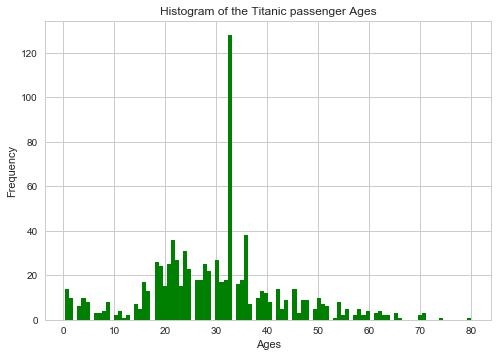

In [52]:
titanic_df['Age'].plot.hist(bins=100, color='green')
Title = 'Histogram of the Titanic passenger Ages'
X = 'Ages'
y = 'Frequency'
plt.title(Title)
plt.xlabel(X)
plt.ylabel(y)     

## 1.6 Drop off unwanted columns

In [53]:
titanic_df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,NumPassengersInCabin,FarePerPassenger,Deck,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,3.62500,G,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,35.64165,C,Mrs


Drop off the following columns:  
Name  
Ticket  
Cabin  
SibSp  
Parch  

In [54]:
titanic_df = titanic_df.drop(columns = ['Name', 'Ticket', 'Cabin', 'FarePerPassenger', 'SibSp', 'Parch'])
titanic_df.head(3)

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,NumPassengersInCabin,Deck,Title
0,1,0,3,male,22.0,7.2500,S,2,G,Mr
1,2,1,1,female,38.0,71.2833,C,2,C,Mrs
2,3,1,3,female,26.0,7.9250,S,1,F,Miss


## 1.7) Convert categorical to numerical 

In [55]:
titanic_df = pd.get_dummies(data=titanic_df, columns=['Sex', 'Embarked', 'Deck', 'Title'])
titanic_df.tail(3)

,PassengerId,Survived,Pclass,Age,Fare,NumPassengersInCabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Title_Don,Title_Dr,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Title_Sir
888,889,0,3,21.845638,23.45,4,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
889,890,1,1,26.000000,30.00,1,0,1,1,0,...,0,0,0,0,0,0,1,0,0,0
890,891,0,3,32.000000,7.75,1,0,1,0,1,...,0,0,0,0,0,0,1,0,0,0


## 1.8) Statistical summary of the prepared dataset: 
Numerical variables

In [56]:
titanic_df.describe()

,PassengerId,Survived,Pclass,Age,Fare,NumPassengersInCabin,Sex_female,Sex_male,Embarked_C,Embarked_Q,...,Title_Don,Title_Dr,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Rev,Title_Sir
count,876.000000,876.000000,876.000000,876.000000,876.000000,876.000000,876.000000,876.000000,876.000000,876.000000,...,876.000000,876.000000,876.000000,876.000000,876.000000,876.000000,876.000000,876.000000,876.000000,876.000000
mean,444.794521,0.389269,2.315068,29.684104,32.755650,1.920091,0.358447,0.641553,0.194064,0.087900,...,0.001142,0.007991,0.001142,0.002283,0.045662,0.211187,0.574201,0.143836,0.006849,0.001142
std,257.806393,0.487863,0.835663,13.349943,49.936826,1.622839,0.479818,0.479818,0.395704,0.283311,...,0.033787,0.089085,0.033787,0.047755,0.208870,0.408384,0.494746,0.351123,0.082524,0.033787
min,1.000000,0.000000,1.000000,0.420000,4.012500,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,220.750000,0.000000,2.000000,21.845638,7.925000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,444.500000,0.000000,3.000000,30.000000,14.500000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,667.250000,1.000000,3.000000,35.788991,31.275000,2.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,891.000000,1.000000,3.000000,80.000000,512.329200,11.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2) Logistic Regression

This is binary classification supervised problem

In [57]:
# Importing modules
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle

In [59]:
X = titanic_df.drop(['PassengerId','Survived'], axis=1)
y = titanic_df.Survived

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
X, y = shuffle(X, y, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(613, 30) (613,) (263, 30) (263,)


In [63]:
# Logistic Regression
# Create logistic regression object
logreg = LogisticRegression(penalty = 'l1', C = 10,random_state = 1)

# Train the model using the training sets and check score
logreg.fit(X_train, y_train)

# Predict Logistic regression output - 0 or 1
log_predicted= logreg.predict(X_test)

# Prediction of probabilities
log_predicted_prob = logreg.predict_proba(X_test)[:,1] 

# Score for train and test
logreg_score = round(logreg.score(X_train, y_train) * 100, 2)
logreg_score_test = round(logreg.score(X_test, y_test) * 100, 2)

In [64]:
print('Logistic Regression Training Score: \n', logreg_score)
print('Logistic Regression Test Score: \n', logreg_score_test)

Logistic Regression Training Score: 
 84.01
Logistic Regression Test Score: 
 81.75


In [65]:
print('Accuracy: \n', accuracy_score(y_test,log_predicted))
print('Confusion Matrix: \n', confusion_matrix(y_test,log_predicted))
print('Classification Report: \n', classification_report(y_test,log_predicted))

Accuracy: 
 0.8174904942965779
Confusion Matrix: 
 [[140  18]
 [ 30  75]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.82      0.89      0.85       158
          1       0.81      0.71      0.76       105

avg / total       0.82      0.82      0.82       263



In [67]:
log_predicted_prob[:10]

array([0.97856005, 0.06147777, 0.25004457, 0.52037484, 0.9329379 ,
       0.01601439, 0.07786239, 0.89412385, 0.12060331, 0.044519  ])

In [69]:
log_predicted[:10] ## All probabilities > 0.5 are 1; else 0

array([1, 0, 0, 1, 1, 0, 0, 1, 0, 0], dtype=int64)

## 2.1) Remove variables with insignificant correlation and execute logistic regression again

In [70]:
titanic_corr = titanic_df.corr()

In [71]:
titanic_corr.Survived

PassengerId             0.000246
Survived                1.000000
Pclass                 -0.351636
Age                    -0.084956
Fare                    0.252453
NumPassengersInCabin    0.010464
Sex_female              0.540800
Sex_male               -0.540800
Embarked_C              0.170640
Embarked_Q              0.000217
Embarked_S             -0.150117
Deck_A                  0.028942
Deck_B                  0.200415
Deck_C                  0.107926
Deck_D                  0.127671
Deck_E                  0.026985
Deck_F                 -0.225896
Deck_G                 -0.045923
Deck_T                  0.010864
Title_Capt             -0.026990
Title_Col               0.010864
Title_Countess          0.042344
Title_Don              -0.026990
Title_Dr                0.007234
Title_Lady              0.042344
Title_Major             0.010864
Title_Master            0.083322
Title_Miss              0.332615
Title_Mr               -0.548314
Title_Mrs               0.339935
Title_Rev 

In [78]:
cols = titanic_corr.Survived[(abs(titanic_corr.Survived)>0.08) & (titanic_corr.Survived !=1) ].index.tolist()
titanic_corr.Survived[(abs(titanic_corr.Survived)>0.08) & (titanic_corr.Survived !=1) ]

Pclass         -0.351636
Age            -0.084956
Fare            0.252453
Sex_female      0.540800
Sex_male       -0.540800
Embarked_C      0.170640
Embarked_S     -0.150117
Deck_B          0.200415
Deck_C          0.107926
Deck_D          0.127671
Deck_F         -0.225896
Title_Master    0.083322
Title_Miss      0.332615
Title_Mr       -0.548314
Title_Mrs       0.339935
Name: Survived, dtype: float64

In [79]:
X1 = titanic_df[cols]
y1 = titanic_df.Survived

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.30)
X, y = shuffle(X, y, random_state=0)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(613, 15) (613,) (263, 15) (263,)


In [81]:
# Logistic Regression with few variables
# Create logistic regression object
logreg = LogisticRegression(penalty = 'l1', C = 10,random_state = 1)

# Train the model using the training sets and check score
logreg.fit(X_train, y_train)

# Predict Logistic regression output - 0 or 1
log_predicted= logreg.predict(X_test)

# Prediction of probabilities
log_predicted_prob = logreg.predict_proba(X_test)[:,1] 

print('Logistic Regression Training Score: \n', logreg_score)
print('Logistic Regression Test Score: \n', logreg_score_test)
print('Accuracy: \n', accuracy_score(y_test,log_predicted))
print('Confusion Matrix: \n', confusion_matrix(y_test,log_predicted))
print('Classification Report: \n', classification_report(y_test,log_predicted))

Logistic Regression Training Score: 
 84.01
Logistic Regression Test Score: 
 81.75
Accuracy: 
 0.8060836501901141
Confusion Matrix: 
 [[140  27]
 [ 24  72]]
Classification Report: 
              precision    recall  f1-score   support

          0       0.85      0.84      0.85       167
          1       0.73      0.75      0.74        96

avg / total       0.81      0.81      0.81       263



There seems to be difference in false negatives and false positives